In [1]:
'''
Задание 1
• Рассчитать результат свертки:
1. Размер входного изображения: 1024 x 1024. Какого размера получится
результат свёртки 5 x 5, со страйдом ( 1 , 1 ), с паддингом ( 1 , 1 ) если на
выходе должно быть 44 каналов.
2. Размер входного изображения: 128 x 128. Какого размера получится
результат свёртки 9 x 9, со страйдом ( 1 , 1 ), с паддингом ( 1 , 1 ) если на
выходе должно быть 9 каналов

Задание 2
• Найти количество параметров в свёрточной нейронной сети:
1) conv2d(channels_input = 4 , channels_output = 4 kernel = ( 7 x 7 ), padding = 3 , stride = ( 3 , 3 )
maxpool
conv2d(channels_input = 4 , channels_output = 6 kernel = ( 5 x 5 ), padding = 2 , stride = ( 1 , 1 )
maxpool
2) conv2d(channels_input = 4 , channels_output = 4 kernel = ( 9 x 9 ), padding = 4 , stride = ( 2 , 2 )
maxpool
conv2d(channels_input = 4 , channels_output = 6 kernel = ( 9 x 9 ), padding = 4 , stride = ( 4 , 4 )
maxpool
conv2d(channels_input = 6 , channels_output = 7 kernel = ( 9 x 9 ), padding = 4 , stride = ( 1 , 1 )
maxpool
conv2d(channels_input = 7 , channels_output = 8 kernel = ( 5 x 5 ), padding = 2 , stride = ( 2 , 2 )
maxpool

((w*h*d)*k)
Смещение для каждой свертки свое. То есть если у нас 4 фильтра, то к всем
весам прибавляется еще 4 смещения.

Задание 3
Построить архитектуру сверточной нейронной сети LeNet для задачи
классификации (данные, например, CIFAR10, можно и другие). Обучить
модель.
• Построить график ошибок для тестовой выборки для старого LeNet и с
разными новыми гиперпараметрами сети. Т.е. добавить ReLu, затем
MaxPool, затем 2 свертки 3*3 вместо 5*5. То есть всего 4 графика на
одном полотне.
• Показать результат работы сети после обучения.
'''

# Загружать в соответствующие библиотеки и при необходимости использовать псевдонимы
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Определите соответствующие переменные для задачи ML
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Устройство само определит, следует ли запускать обучение на графическом процессоре или CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#///////////////////////////////////////////////
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((22,22)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((22,22)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

#/////////////////////////////////////////////////////////

#Определение сверточной нейронной сети
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(144, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        #print(x.shape)
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

  #////////////////////////

model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Настройка оптимизатора с учетом параметров модели и скорости обучения
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#это определено для того, чтобы вывести количество оставшихся шагов при обучении
total_step = len(train_loader)

#///////////////////////////


from sklearn.metrics import f1_score

total_step = len(train_loader)

accuracys_train = []
accuracys_test = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_outs = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu())
            all_outs.extend(predicted.cpu())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracys_test.append(100 * correct / total)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


#///////////////////////////////////////////////

#Определение сверточной нейронной сети
class LeNet_ReLU(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(144, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        #print(x.shape)
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

    #////////////////////////////////////////////////////

model = LeNet_ReLU(num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



100%|██████████| 9912422/9912422 [00:00<00:00, 78071614.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 128321709.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51699095.45it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1234882.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/10], Step [400/938], Loss: 1.5470
Epoch [1/10], Step [800/938], Loss: 1.5167
Accuracy of the network on the 10000 test images: 94.82 %
Epoch [2/10], Step [400/938], Loss: 1.4962
Epoch [2/10], Step [800/938], Loss: 1.4838
Accuracy of the network on the 10000 test images: 96.76 %
Epoch [3/10], Step [400/938], Loss: 1.4786
Epoch [3/10], Step [800/938], Loss: 1.4652
Accuracy of the network on the 10000 test images: 97.39 %
Epoch [4/10], Step [400/938], Loss: 1.5241
Epoch [4/10], Step [800/938], Loss: 1.4763
Accuracy of the network on the 10000 test images: 97.82 %
Epoch [5/10], Step [400/938], Loss: 1.5169
Epoch [5/10], Step [800/938], Loss: 1.4716
Accuracy of the network on the 10000 test images: 98.01 %
Epoch [6/10], Step [400/938], Loss: 1.4887
Epoch [6/10], Step [800/938], Loss: 1.4828
Accuracy of the network on the 10000 test images: 97.9 %
Epoch [7/10], Step [400/938], Loss: 1.4731
Epoch [7/10], Step [800/938], Loss: 1.4766
Accuracy of the network on the 10000 test images: 9

In [2]:
from sklearn.metrics import f1_score

total_step = len(train_loader)

accuracys_test_relu = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_outs = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu())
            all_outs.extend(predicted.cpu())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracys_test_relu.append(100 * correct / total)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/10], Step [400/938], Loss: 1.6144
Epoch [1/10], Step [800/938], Loss: 1.5385
Accuracy of the network on the 10000 test images: 94.6 %
Epoch [2/10], Step [400/938], Loss: 1.5118
Epoch [2/10], Step [800/938], Loss: 1.5216
Accuracy of the network on the 10000 test images: 96.46 %
Epoch [3/10], Step [400/938], Loss: 1.5068
Epoch [3/10], Step [800/938], Loss: 1.4623
Accuracy of the network on the 10000 test images: 96.78 %
Epoch [4/10], Step [400/938], Loss: 1.4988
Epoch [4/10], Step [800/938], Loss: 1.5088
Accuracy of the network on the 10000 test images: 97.31 %
Epoch [5/10], Step [400/938], Loss: 1.5144
Epoch [5/10], Step [800/938], Loss: 1.4746
Accuracy of the network on the 10000 test images: 97.35 %
Epoch [6/10], Step [400/938], Loss: 1.5345
Epoch [6/10], Step [800/938], Loss: 1.4612
Accuracy of the network on the 10000 test images: 97.57 %
Epoch [7/10], Step [400/938], Loss: 1.4894
Epoch [7/10], Step [800/938], Loss: 1.4735
Accuracy of the network on the 10000 test images: 9

### MaxPool

In [ ]:
class LeNet_MaxPool(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(144, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [ ]:
model = LeNet_MaxPool(num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import f1_score

total_step = len(train_loader)

accuracys_test_maxpool = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_outs = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu())
            all_outs.extend(predicted.cpu())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracys_test_maxpool.append(100 * correct / total)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/10], Step [400/938], Loss: 1.5866
Epoch [1/10], Step [800/938], Loss: 1.5345
Accuracy of the network on the 10000 test images: 95.89 %
Epoch [2/10], Step [400/938], Loss: 1.4715
Epoch [2/10], Step [800/938], Loss: 1.5829
Accuracy of the network on the 10000 test images: 97.37 %
Epoch [3/10], Step [400/938], Loss: 1.4773
Epoch [3/10], Step [800/938], Loss: 1.4612
Accuracy of the network on the 10000 test images: 97.72 %
Epoch [4/10], Step [400/938], Loss: 1.4994
Epoch [4/10], Step [800/938], Loss: 1.4846
Accuracy of the network on the 10000 test images: 97.84 %
Epoch [5/10], Step [400/938], Loss: 1.4953
Epoch [5/10], Step [800/938], Loss: 1.4985
Accuracy of the network on the 10000 test images: 98.11 %
Epoch [6/10], Step [400/938], Loss: 1.4622
Epoch [6/10], Step [800/938], Loss: 1.4882
Accuracy of the network on the 10000 test images: 97.95 %
Epoch [7/10], Step [400/938], Loss: 1.4770
Epoch [7/10], Step [800/938], Loss: 1.4632
Accuracy of the network on the 10000 test images: 

### 2 kernel 3*3

In [ ]:
class LeNet_TwoKernel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(144, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [ ]:
model = LeNet_TwoKernel(num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import f1_score

total_step = len(train_loader)

accuracys_test_twokernel = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_outs = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu())
            all_outs.extend(predicted.cpu())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracys_test_twokernel.append(100 * correct / total)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/10], Step [400/938], Loss: 1.5826
Epoch [1/10], Step [800/938], Loss: 1.6201
Accuracy of the network on the 10000 test images: 87.39 %
Epoch [2/10], Step [400/938], Loss: 1.5983
Epoch [2/10], Step [800/938], Loss: 1.6139
Accuracy of the network on the 10000 test images: 88.62 %
Epoch [3/10], Step [400/938], Loss: 1.6008
Epoch [3/10], Step [800/938], Loss: 1.5849
Accuracy of the network on the 10000 test images: 88.75 %
Epoch [4/10], Step [400/938], Loss: 1.6012
Epoch [4/10], Step [800/938], Loss: 1.6620
Accuracy of the network on the 10000 test images: 88.07 %
Epoch [5/10], Step [400/938], Loss: 1.5292
Epoch [5/10], Step [800/938], Loss: 1.5566
Accuracy of the network on the 10000 test images: 89.19 %
Epoch [6/10], Step [400/938], Loss: 1.5918
Epoch [6/10], Step [800/938], Loss: 1.5548
Accuracy of the network on the 10000 test images: 88.87 %
Epoch [7/10], Step [400/938], Loss: 1.5237
Epoch [7/10], Step [800/938], Loss: 1.4614
Accuracy of the network on the 10000 test images: 

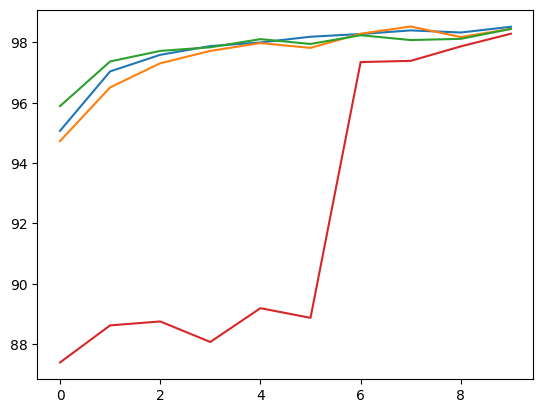

In [ ]:
from matplotlib import pyplot as plt

plt.plot(accuracys_test)
plt.plot(accuracys_test_relu)
plt.plot(accuracys_test_maxpool)
plt.plot(accuracys_test_twokernel)

## Test

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_outs = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu())
        all_outs.extend(predicted.cpu())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy of the network on the 10000 test images: 98.4 %


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_outs))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

